# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
1. [Introduction: Business Problem](#introduction)
2. [Data](#data)
3. [Methodology](#methodology)
4. [Analysis](#analysis)
5. [Results and Discussion](#results)
6. [Conclusion](#conclusion)



## 1. Introduction: Business Problem <a name="introduction"></a>

New York City is a multicultural city most popular in the United State. The population of New York City is very diverse in ethnicity, which includes non-Hispanic white (English, Italian, Irish, Russian, etc.), Hispanics White(Dominican, Puerto Rican, etc.), black(African, Caribbean, etc.), Asian(Chinese, Japanese, Korean, Indian, etc.).

Most people like to live in a neighborhood with those of their own ethnic group. Identifying the dominant race of each neighborhood would be helpful to those who want to live or do business in New York City.

In this study, we will try to identify the ethnicity of each neighborhood in New York City based on their food culture, specifically, the categories of **Food Venues** from location data.

In [1]:
import numpy as np
import pandas as pd

import requests
import json

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

from geopy.geocoders import Nominatim

import folium

import pickle

## 2. Data <a name="data"></a>

### Neighborhood Data

Before we start, let's download the neighborhood data and prepare the data into a DataFrame.

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
import json
from pandas.io.json import json_normalize

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    neighborhoods = json_normalize(newyork_data['features'])
neighborhoods.head()

,geometry.coordinates,geometry.type,geometry_name,id,properties.annoangle,properties.annoline1,properties.annoline2,properties.annoline3,properties.bbox,properties.borough,properties.name,properties.stacked,type
0,"[-73.84720052054902, 40.89470517661]",Point,geom,nyu_2451_34572.1,0.0,Wakefield,None,None,"[-73.84720052054902, 40.89470517661, -73.84720...",Bronx,Wakefield,1,Feature
1,"[-73.82993910812398, 40.87429419303012]",Point,geom,nyu_2451_34572.2,0.0,Co-op,City,None,"[-73.82993910812398, 40.87429419303012, -73.82...",Bronx,Co-op City,2,Feature
2,"[-73.82780644716412, 40.887555677350775]",Point,geom,nyu_2451_34572.3,0.0,Eastchester,None,None,"[-73.82780644716412, 40.887555677350775, -73.8...",Bronx,Eastchester,1,Feature
3,"[-73.90564259591682, 40.89543742690383]",Point,geom,nyu_2451_34572.4,0.0,Fieldston,None,None,"[-73.90564259591682, 40.89543742690383, -73.90...",Bronx,Fieldston,1,Feature
4,"[-73.9125854610857, 40.890834493891305]",Point,geom,nyu_2451_34572.5,0.0,Riverdale,None,None,"[-73.9125854610857, 40.890834493891305, -73.91...",Bronx,Riverdale,1,Feature


Let's clean the data and make another DataFrame with columns of the neighborhood, borough name and latitude, longitude.

In [4]:
neighborhoods = neighborhoods.apply(lambda x: pd.Series([x['properties.name'], x['properties.borough'], x['geometry.coordinates'][1], x['geometry.coordinates'][0]],
                                                        index=['Neighborhood', 'Borough', 'Latitude', 'Longitude']), axis=1)
neighborhoods.head()

,Neighborhood,Borough,Latitude,Longitude
0,Wakefield,Bronx,40.894705,-73.847201
1,Co-op City,Bronx,40.874294,-73.829939
2,Eastchester,Bronx,40.887556,-73.827806
3,Fieldston,Bronx,40.895437,-73.905643
4,Riverdale,Bronx,40.890834,-73.912585


In [5]:
neighborhoods.shape

(306, 4)

### Restaurant Data

Now, let's collect restaurant data for each neighborhoods using Foursquare API.

Foursquare credentials are defined in hidden cell bellow.

In [6]:
# @hidden_cell
CLIENT_ID='K11CKZSMUKX4N1K4JXVGGCJYO4PUPRGJFRCS0YUGXU3FXR3G'
CLIENT_SECRET='GZAMXHIFE4WV2LD2TSW4CBD4WFGQRXTLHITMV3UAI1ONH4WO'
VERSION = '20180605'
LIMIT=100
RADIUS=500

#### Food Categories

First, let's get all sub categories of food.

In [7]:
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}&includeSupportedCC=true'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
food_categories = requests.get(url).json()['response']['categories'][3]['categories']
food_categories[0:3]

[{'id': '503288ae91d4c4b30a586d67',
  'name': 'Afghan Restaurant',
  'pluralName': 'Afghan Restaurants',
  'shortName': 'Afghan',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/afghan_',
   'suffix': '.png'},
  'countryCodes': [],
  'categories': []},
 {'id': '4bf58dd8d48988d1c8941735',
  'name': 'African Restaurant',
  'pluralName': 'African Restaurants',
  'shortName': 'African',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/african_',
   'suffix': '.png'},
  'countryCodes': [],
  'categories': [{'id': '4bf58dd8d48988d10a941735',
    'name': 'Ethiopian Restaurant',
    'pluralName': 'Ethiopian Restaurants',
    'shortName': 'Ethiopian',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/ethiopian_',
     'suffix': '.png'},
    'countryCodes': [],
    'categories': []}]},
 {'id': '4bf58dd8d48988d14e941735',
  'name': 'American Restaurant',
  'pluralName': 'American Restaurants',
  'shortName': 'American',
  'icon': {'prefix': 'ht

Let's format the categories into a DataFrame with category Id, Name, ParentId.

In [8]:
def format_categories(parent_id, categories):
    formated = [] # id, name, parentId
    for category in categories:
        formated.append([category['id'], category['name'], parent_id])
        if len(category['categories']) != 0:
            formated.extend(format_categories(category['id'], category['categories']))
    return formated

food_categories_df = pd.DataFrame(format_categories(None, food_categories), columns=['Id', 'Name', 'ParentId'])
food_categories_df.head()

,Id,Name,ParentId
0,503288ae91d4c4b30a586d67,Afghan Restaurant,None
1,4bf58dd8d48988d1c8941735,African Restaurant,None
2,4bf58dd8d48988d10a941735,Ethiopian Restaurant,4bf58dd8d48988d1c8941735
3,4bf58dd8d48988d14e941735,American Restaurant,None
4,4bf58dd8d48988d157941735,New American Restaurant,4bf58dd8d48988d14e941735


In [9]:
food_categories_df.count()

Id          347
Name        347
ParentId    256
dtype: int64

#### Food Venues

Now we know there are 347 food categories, and 256 of them have parentId. 

In [10]:
food_category_ids = food_categories_df['Id'].values

def get_parent(id, up_level=1, food_categories_df=food_categories_df):
    parent = (None, None) # id, name
    while(up_level != 0):
        parent_id = food_categories_df[food_categories_df['Id'] == id]['ParentId'].values[0]
        if parent_id == None:
            parent = (None, None)
            break
        else:
            p = food_categories_df[food_categories_df['Id'] == parent_id].values[0]
            parent = (p[0], p[1])
        up_level = up_level - 1
    return parent

def get_food_venues_nearby(neighborhood, borough, lat, lon):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&section=food&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, RADIUS, LIMIT)
    results = requests.get(url).json()['response']['groups'][0]['items']
    venues = [[item['venue']['id'],
                item['venue']['name'],
                item['venue']['location']['lat'], item['venue']['location']['lng'],
                item['venue']['categories'][0]['id'], item['venue']['categories'][0]['name'],
                neighborhood, borough, lat, lon] for item in results]
    print(neighborhood, 'venues count: ', len(venues))
    return venues

def get_category_venue_count(df):
    category_venue_count = df.loc[:,['VenueName', 'VenueCategoryName']].groupby('VenueCategoryName').count().sort_values(['VenueName'], ascending=False)
    category_venue_count.rename(columns = {'VenueName': 'Count'}, inplace=True)
    return category_venue_count

Let's get food venues for all neighborhoods.

In [49]:
loaded = False

try:
    with open('food_venues_df.pkl', 'rb') as f: 
        food_venues_df = pickle.load(f) #read data from backup.
    loaded = True
except:
    pass

if not loaded:
    food_venues = []
    for index, row in neighborhoods.iterrows():
        food_venues.extend(get_food_venues_nearby(row[0], row[1], row[2], row[3]))  
    food_venues_df = pd.DataFrame(food_venues, 
                                  columns=['VenueId', 'VenueName',
                                           'VenueLatitude', 'VenueLongitude',
                                           'VenueCategoryId', 'VenueCategoryName',
                                           'Neighborhood', 'Borough', 'Latitude', 'Longitude'])
    with open('food_venues_df.pkl', 'wb') as f:
         pickle.dump(food_venues_df, f) #We'll save the data for backup.

food_venues_df.head()

,VenueId,VenueName,VenueLatitude,VenueLongitude,VenueCategoryId,VenueCategoryName,Neighborhood,Borough,Latitude,Longitude
0,508af256e4b0578944c87392,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,4bf58dd8d48988d144941735,Caribbean Restaurant,Wakefield,Bronx,40.894705,-73.847201
1,4c25c212f1272d7f836385c5,Dunkin',40.890459,-73.849089,4bf58dd8d48988d148941735,Donut Shop,Wakefield,Bronx,40.894705,-73.847201
2,4d33665fb6093704b80001e0,SUBWAY,40.890656,-73.849192,4bf58dd8d48988d1c5941735,Sandwich Place,Wakefield,Bronx,40.894705,-73.847201
3,4e440828a809d4ed1bb7059f,Pitman Deli,40.894149,-73.845748,4d4b7105d754a06374d81259,Food,Wakefield,Bronx,40.894705,-73.847201
4,4eb046abb8f7116f21081aeb,Baychester Avenue Food Truck,40.892293,-73.843230,4bf58dd8d48988d1cb941735,Food Truck,Wakefield,Bronx,40.894705,-73.847201


Let's see how many food venues and categories.

In [50]:
print('Number of food venues: {}'.format(food_venues_df.shape[0]))
print('Number of neighborhoods: {}'.format(len(food_venues_df['Neighborhood'].unique())))
category_venue_count = get_category_venue_count(food_venues_df)
print('Number of categories: {}'.format(category_venue_count.shape[0]))
category_venue_count.head()

Number of food venues: 8347
Number of neighborhoods: 291
Number of categories: 137


,Count
VenueCategoryName,
Pizza Place,758
Deli / Bodega,733
Chinese Restaurant,510
Italian Restaurant,485
Bakery,352


Let's reduce the category size by set the category name with low venue count(<100) to their parent category if exist. Repeat this multiple times until category count not changing.

In [52]:
low_count_categories = category_venue_count[category_venue_count['Count']<100].index.values

def get_parent_by_item(x, low_count_categories=low_count_categories):
    if x['VenueCategoryName'] in low_count_categories:
        id, name = get_parent(x['VenueCategoryId'])
        if id != None :
            return pd.Series([id, name], index=['VenueCategoryId', 'VenueCategoryName'])
    return pd.Series([x['VenueCategoryId'], x['VenueCategoryName']], index=['VenueCategoryId', 'VenueCategoryName'])
parent_df = food_venues_df.apply(get_parent_by_item, axis=1)

food_venues_df.update(parent_df)
category_venue_count = food_venues_df.loc[:,['VenueName', 'VenueCategoryName']].groupby('VenueCategoryName').count().sort_values(['VenueName'], ascending=False)
category_venue_count.rename(columns = {'VenueName': 'Count'}, inplace=True)
print(category_venue_count.shape)
category_venue_count.head()

(84, 1)


,Count
VenueCategoryName,
Pizza Place,758
Deli / Bodega,733
Chinese Restaurant,559
Italian Restaurant,485
Mexican Restaurant,375


We can see the category size is reduce to 84.

Now, let's take a look at the categories with count greater than 100.

In [53]:
category_venue_count[category_venue_count['Count']>100]

,Count
VenueCategoryName,
Pizza Place,758
Deli / Bodega,733
Chinese Restaurant,559
Italian Restaurant,485
Mexican Restaurant,375
American Restaurant,360
Bakery,352
Sandwich Place,302
Café,295


And Let's only select those categories with clear cultural or geographical background. (`Sushi Restaurant` can also be merged into `Japanese Restaurant`.)

In [54]:
food_venues_df.loc[food_venues_df['VenueCategoryName'] == 'Sushi Restaurant', ['VenueCategoryId', 'VenueCategoryName']] = ['4bf58dd8d48988d111941735', 'Japanese Restaurant']
category_names = [
'Chinese Restaurant',
'Italian Restaurant',
'Mexican Restaurant',
'American Restaurant',
'Asian Restaurant',
'Latin American Restaurant',
'Japanese Restaurant',
'Spanish Restaurant',
'Thai Restaurant',
'Caribbean Restaurant',
'Indian Restaurant',
'Korean Restaurant',
'French Restaurant',
'Mediterranean Restaurant',
'Greek Restaurant',
'Middle Eastern Restaurant',
'Eastern European Restaurant',
'Hawaiian Restaurant',
'Turkish Restaurant',
'African Restaurant',
'German Restaurant',
'Jewish Restaurant',
'Russian Restaurant',
'Polish Restaurant',
'Halal Restaurant',
'Irish Pub',
'Australian Restaurant',
'Pakistani Restaurant',
'Sri Lankan Restaurant',
'Afghan Restaurant',
'Swiss Restaurant',
'English Restaurant',
'Austrian Restaurant',
'Caucasian Restaurant',
'Scandinavian Restaurant',
'Belgian Restaurant',
'Ukrainian Restaurant',
'Modern European Restaurant',
'Portuguese Restaurant',
'Czech Restaurant']

food_venues_filtered = food_venues_df[[item in category_names for (index,item) in food_venues_df['VenueCategoryName'].items()]]
print('Number of food venues: {}'.format(food_venues_filtered.shape[0]))
print('Number of neighborhoods: {}'.format(len(food_venues_filtered['Neighborhood'].unique())))
category_venue_count = get_category_venue_count(food_venues_filtered)
print('Number of categories: {}'.format(category_venue_count.shape[0]))
category_venue_count

Number of food venues: 3805
Number of neighborhoods: 271
Number of categories: 40


,Count
VenueCategoryName,
Chinese Restaurant,559
Italian Restaurant,485
Japanese Restaurant,387
Mexican Restaurant,375
American Restaurant,360
Asian Restaurant,233
Latin American Restaurant,220
Spanish Restaurant,151
Thai Restaurant,135


In [55]:
food_venues_filtered.head()

,VenueId,VenueName,VenueLatitude,VenueLongitude,VenueCategoryId,VenueCategoryName,Neighborhood,Borough,Latitude,Longitude
0,508af256e4b0578944c87392,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,4bf58dd8d48988d144941735,Caribbean Restaurant,Wakefield,Bronx,40.894705,-73.847201
9,4c9d5f2654c8a1cd2e71834b,Guang Hui Chinese Restaurant,40.876603,-73.829710,4bf58dd8d48988d145941735,Chinese Restaurant,Co-op City,Bronx,40.874294,-73.829939
16,515cc20ce4b0deb133b8e89b,Fish & Ting,40.885539,-73.829151,4bf58dd8d48988d144941735,Caribbean Restaurant,Eastchester,Bronx,40.887556,-73.827806
22,4c632fbaeb82d13a3c5007d6,Golden Krust Caribbean Bakery and Grill,40.888543,-73.831278,4bf58dd8d48988d144941735,Caribbean Restaurant,Eastchester,Bronx,40.887556,-73.827806
25,4dbf84a24df0f8fd6b88c9b6,Royal Caribbean Bakery,40.888252,-73.831457,4bf58dd8d48988d144941735,Caribbean Restaurant,Eastchester,Bronx,40.887556,-73.827806


## 3. Methodology <a name="methodology"></a>

In this project, we'll try to cluster neighborhoods in New York City and assign each neighborhood an ethnic label based on the categories of venues nearby using k-means algorithms. We already prepared 40 ethnic food categories and 3805 venues of 271 neighborhoods. Before we start clustering, let's first define our neighborhood feature matrix to be used to solve the problem.

1. For one neighborhood, the vector of venue count of each categories denote as:

   $$\vec C = (c_1, c_2, \cdots, c_n)$$

2. As we only consider how much portion each category contribute to the final ethnic label of the neighborhood, we'll define neighborhood feature vector as:

    $$\vec F = \frac{\vec C}{\sum_{i=1}^n{c_i}}$$

3. For all $m$ neighborhood, we got our feature matrix as:

    $$F =
    \begin{pmatrix}
    \vec F_1\\
    \vec F_2\\
    \vdots\\
    \vec F_m\\
    \end{pmatrix}$$

After clustering, we need to examine the cluster and assign each cluster an label. Suppose we got $k$ clusters. For each cluster with $N$ neighborhoods, we use the mean to evaluate category contribution. We got our cluster evaluation matrix as:

  $$ E =
    \begin{pmatrix}
    \frac{\sum_{i=1}^{N_1} \vec F_i}{N_1} \\
    \frac{\sum_{i=1}^{N_2} \vec F_i}{N_2} \\
    \vdots\\
    \frac{\sum_{i=1}^{N_k} \vec F_i}{N_k} \\
    \end{pmatrix}$$


In the next section, we'll first try to cluster neighborhoods using k-means based on all 40 category features to see if we were able to assign labels for the result clusters. Then, we'll manually merge categories into some large categories, such as `White`, `Black`, `Hispanic`, `East Asian` etc., and cluster again to see if we can get a better result.

Finally, we'll check if the result is correct or somewhat comparable to the real demographic data of New York City.

## 4. Analysis <a name="analysis"></a>

### 4.1 First Clustering

Let's first create the neighborhood category feature matrix by counting the venues of each category in each neighborhood.

In [56]:
venue_count = pd.crosstab(food_venues_filtered['Neighborhood'], food_venues_filtered['VenueCategoryName'])
venue_count = venue_count[category_names] # reorder columns
venue_count.head()

VenueCategoryName,Chinese Restaurant,Italian Restaurant,Mexican Restaurant,American Restaurant,Asian Restaurant,Latin American Restaurant,Japanese Restaurant,Spanish Restaurant,Thai Restaurant,Caribbean Restaurant,...,Swiss Restaurant,English Restaurant,Austrian Restaurant,Caucasian Restaurant,Scandinavian Restaurant,Belgian Restaurant,Ukrainian Restaurant,Modern European Restaurant,Portuguese Restaurant,Czech Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Allerton,3,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Annadale,0,0,0,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arlington,0,0,0,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Arrochar,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arverne,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


As we only consider which categories relatively contribute more to the neighborhood, we'll divide each row by the sum of count in each row to normalize the data.

In [57]:
venue_count_normalized = venue_count.apply(lambda x: x/x.sum(), axis=1)
venue_count_normalized = venue_count_normalized.dropna()
venue_count_normalized.head()

VenueCategoryName,Chinese Restaurant,Italian Restaurant,Mexican Restaurant,American Restaurant,Asian Restaurant,Latin American Restaurant,Japanese Restaurant,Spanish Restaurant,Thai Restaurant,Caribbean Restaurant,...,Swiss Restaurant,English Restaurant,Austrian Restaurant,Caucasian Restaurant,Scandinavian Restaurant,Belgian Restaurant,Ukrainian Restaurant,Modern European Restaurant,Portuguese Restaurant,Czech Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Allerton,0.5,0.000000,0.166667,0.166667,0.0,0.0,0.00,0.166667,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Annadale,0.0,0.000000,0.000000,0.750000,0.0,0.0,0.25,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Arlington,0.0,0.000000,0.000000,0.666667,0.0,0.0,0.00,0.000000,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Arrochar,0.0,0.333333,0.166667,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Arverne,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Clustering

Let's first see if we can choose the best K for KMeans using elbow method.

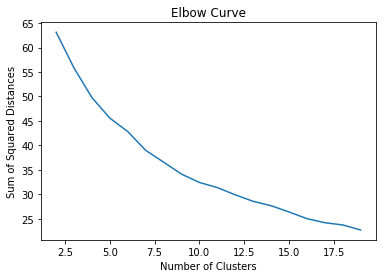

In [58]:
n_clusters = range(2, 20)

kmeans = [KMeans(n_clusters = i, random_state=0).fit(venue_count_normalized) for i in n_clusters]
inertias = [kmean.inertia_ for kmean in kmeans]

plt.plot(n_clusters, inertias)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Curve')

plt.show()

In [59]:
# we'll set K to 8
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(venue_count_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([6, 0, 0, 1, 1, 1, 2, 1, 6, 1], dtype=int32)

In [60]:
# add clustering labels
venue_count_normalized.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhood_merged = venue_count_normalized

neighborhood_merged = neighborhood_merged.merge(neighborhoods, on='Neighborhood')

neighborhood_merged.head() # check the last columns!

,Neighborhood,Cluster Labels,Chinese Restaurant,Italian Restaurant,Mexican Restaurant,American Restaurant,Asian Restaurant,Latin American Restaurant,Japanese Restaurant,Spanish Restaurant,...,Caucasian Restaurant,Scandinavian Restaurant,Belgian Restaurant,Ukrainian Restaurant,Modern European Restaurant,Portuguese Restaurant,Czech Restaurant,Borough,Latitude,Longitude
0,Allerton,6,0.5,0.000000,0.166667,0.166667,0.0,0.0,0.00,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bronx,40.865788,-73.859319
1,Annadale,0,0.0,0.000000,0.000000,0.750000,0.0,0.0,0.25,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Staten Island,40.538114,-74.178549
2,Arlington,0,0.0,0.000000,0.000000,0.666667,0.0,0.0,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Staten Island,40.635325,-74.165104
3,Arrochar,1,0.0,0.333333,0.166667,0.000000,0.0,0.0,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Staten Island,40.596313,-74.067124
4,Arverne,1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Queens,40.589144,-73.791992


#### Examine Clusters 

Let's examine each cluster, printing the size of the cluster and the mean of each category's contribution.

In [61]:
cluster_infos = []
cluster_columns = ['Size']
cluster_columns.extend(category_names)
for i in range(kclusters):
    cluster = neighborhood_merged[neighborhood_merged['Cluster Labels']==i]
    cluster_info = [cluster.shape[0]]
    print('Cluster {}: size({})'.format(i+1,cluster.shape[0]))
    category_contributions = cluster.iloc[:, 2:-3].mean()
    cluster_info.extend(category_contributions.values)
    print(category_contributions.sort_values(ascending=False))
    print('')
    cluster_infos.append(cluster_info)
cluster_info_df = pd.DataFrame(cluster_infos, columns=cluster_columns, index=['Cluster {}'.format(i+1) for i in range(kclusters) ])
cluster_info_df

Cluster 1: size(12)
American Restaurant            0.690972
Italian Restaurant             0.090278
African Restaurant             0.041667
Mexican Restaurant             0.038194
Caribbean Restaurant           0.027778
Latin American Restaurant      0.027778
Japanese Restaurant            0.027778
Spanish Restaurant             0.020833
Asian Restaurant               0.010417
Chinese Restaurant             0.010417
Indian Restaurant              0.006944
Middle Eastern Restaurant      0.006944
Afghan Restaurant              0.000000
Mediterranean Restaurant       0.000000
Modern European Restaurant     0.000000
Ukrainian Restaurant           0.000000
Belgian Restaurant             0.000000
Scandinavian Restaurant        0.000000
Caucasian Restaurant           0.000000
Austrian Restaurant            0.000000
English Restaurant             0.000000
Thai Restaurant                0.000000
Swiss Restaurant               0.000000
Korean Restaurant              0.000000
French Restaurant   

,Size,Chinese Restaurant,Italian Restaurant,Mexican Restaurant,American Restaurant,Asian Restaurant,Latin American Restaurant,Japanese Restaurant,Spanish Restaurant,Thai Restaurant,...,Swiss Restaurant,English Restaurant,Austrian Restaurant,Caucasian Restaurant,Scandinavian Restaurant,Belgian Restaurant,Ukrainian Restaurant,Modern European Restaurant,Portuguese Restaurant,Czech Restaurant
Cluster 1,12,0.010417,0.090278,0.038194,0.690972,0.010417,0.027778,0.027778,0.020833,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Cluster 2,92,0.065869,0.132978,0.088468,0.107011,0.078478,0.021739,0.141399,0.017331,0.047972,...,0.000515,0.000732,0.000396,0.001005,0.000626,0.00032,0.000892,0.000542,0.000413,0.000198
Cluster 3,23,0.183455,0.599794,0.026398,0.033402,0.029676,0.001553,0.060576,0.018634,0.006211,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Cluster 4,9,0.148148,0.027778,0.022222,0.000000,0.013889,0.036111,0.055556,0.626852,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Cluster 5,14,0.197619,0.000000,0.014286,0.000000,0.038095,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Cluster 6,20,0.844048,0.016667,0.025000,0.000000,0.007143,0.010000,0.000000,0.018333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Cluster 7,52,0.366409,0.082892,0.048505,0.074175,0.073154,0.038067,0.087211,0.051361,0.026360,...,0.000000,0.000275,0.000275,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Cluster 8,53,0.192995,0.030411,0.222237,0.049451,0.023903,0.233358,0.023998,0.077823,0.031779,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


To better illustrate the result, let's plot top 10 categories for each cluster in pie chart.

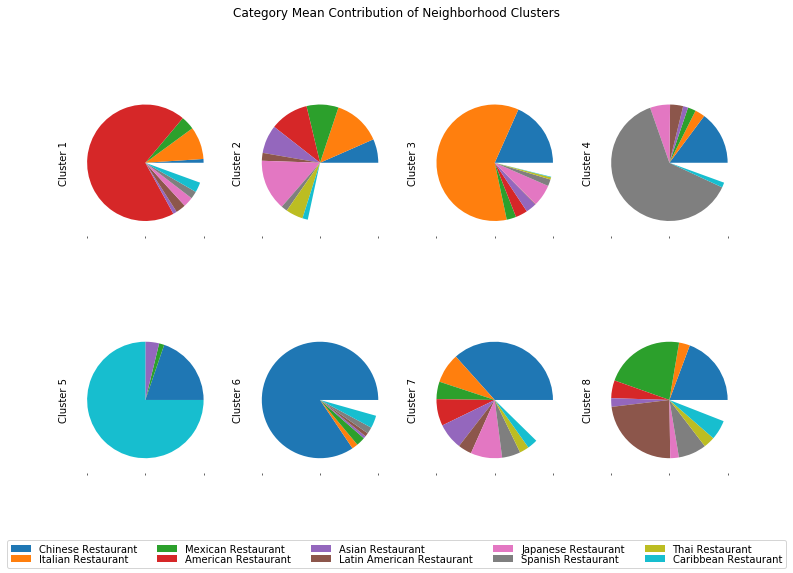

In [62]:
axes = cluster_info_df[category_names].transpose()[0:10].plot(kind='pie', subplots=True, layout=(2,4), figsize=(12, 8), legend=False, labels=None, title="Category Mean Contribution of Neighborhood Clusters")
plt.figlegend(axes[0][0].patches, category_names, loc='lower center', ncol=5, labelspacing=0.)

We can see in the result (the cluster order may change):

1. The first cluster is dominant with **American Restaurant**. We'll call it **American**.
2. The second cluster is so diverse. We'll just call it **Diverse**.
3. The third cluster is dominant with **Italian Restaurant**. We'll call it **Italian**.
4. The forth cluster is dominant with **Spanish Restaurant**. We'll call it **Spanish**.
5. The fifth cluster is dominant with **Caribbean Restaurant**. We'll call it **Caribbean**.
6. The sixth cluster is dominant with **Chinese Restaurant**. We'll call it **Chinese**.
7. The seventh cluster is top with **Chinese Restaurant**, but diverse with many others. We'll call it **Chinese diverse**.
8. The eighth cluster is dominant with **Latin American Restaurant**, **Spanish Restaurant** and **Mexican Restaurant**. We may label it **Hispanic**.

#### Visualize Cluster

Let's visualize the clusters with different colors on the map.

In [25]:
address = 'New York City'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [26]:
cluster_names = ['American', 'Diverse', 'Italian', 'Spanish', 'Caribbean', 'Chinese', 'Chinese diverse', 'Hispanic']

def draw_map_clusters(neighborhood_merged, cluster_names=cluster_names, cluster_colors=None):
    # create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='Mapbox Bright')

    borough_json = json.load(open('newyork_borough.json', 'r')) # borough geojson data downloaded from https://geo.nyu.edu/catalog/nyu-2451-34155
    if not cluster_colors:
        x = np.arange(kclusters)
        ys = [i + x + (i*x)**2 for i in range(kclusters)]
        colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
        cluster_colors = [colors.rgb2hex(i) for i in colors_array]

    legend_items = ''.join(['<div style="text-align:right;line-height:24px;">{}: <span style="color:{}">⬤</span></div>'.format(name, color) for name,color in zip(cluster_names, cluster_colors)])

    legend_html = '''
         <div style="position: fixed; bottom: 10px; right: 10px; width: 200px; height: 250px; 
         border:1px solid grey; border-radius:5px; padding: 10px; background:#fff;
         z-index:9999; font-size:14px;
         "><h5 style="text-align:center">Neighborhood Clusters</h5>
         {}
          </div>
         '''.format(legend_items)

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(neighborhood_merged['Latitude'], neighborhood_merged['Longitude'], neighborhood_merged['Neighborhood'], neighborhood_merged['Cluster Labels']):
        label = folium.Popup(str(poi) + ' [' + cluster_names[cluster] + ']', parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=4,
            popup=label,
            color=cluster_colors[cluster],
            fill=True,
            fill_color=cluster_colors[cluster],
            fill_opacity=0.7).add_to(map_clusters)

    folium.GeoJson(borough_json, style_function=lambda x: {'fill': False}, name='geojson').add_to(map_clusters) # add borough border
    map_clusters.get_root().html.add_child(folium.Element(legend_html)) #add color legend
    return map_clusters

draw_map_clusters(neighborhood_merged, cluster_names=cluster_names)


We can see those infos from this map:

1. Most neighborhoods on `Staten Island` are **Italian** dominant;
2. Almost all neighborhoods in `Manhattan` are labeled **Diverse**;
3. **Hispanic** neighborhoods are distributed in `The Bronx` and `Queens`;
4. **Caribbean** neighborhoods are mainly located in three geographical clusters in `The Bronx` and `Queens` and `Brooklyn`;

### 4.2 Second Clustering

As we can see from the clustering result. The cluster of `Diverse` is too large and the categories contribute evenly. What if we merge those categories into more general ones. To further reduce the category size, we'll manually merge categories based on their culture or geographical location. 

In [27]:
white_categories = [    'Italian Restaurant',
                        'American Restaurant',
                        'French Restaurant',
                        'Mediterranean Restaurant',
                        'Greek Restaurant',
                        'Eastern European Restaurant',
                        'German Restaurant',
                        'Jewish Restaurant',
                        'Russian Restaurant',
                        'Polish Restaurant',
                        'Irish Pub',
                        'Hawaiian Restaurant',
                        'Swiss Restaurant',
                        'English Restaurant',
                        'Australian Restaurant',
                        'Austrian Restaurant',
                        'Caucasian Restaurant',
                        'Scandinavian Restaurant',
                        'Belgian Restaurant',
                        'Ukrainian Restaurant',
                        'Modern European Restaurant',
                        'Portuguese Restaurant',
                        'Czech Restaurant']
hispanic_categories = ['Mexican Restaurant',
                       'Latin American Restaurant',
                       'Spanish Restaurant']
east_asian_categories = ['Chinese Restaurant',
                         'Japanese Restaurant',
                         'Korean Restaurant']
other_asian_categories = ['Middle Eastern Restaurant',
                          'Turkish Restaurant',
                          'Halal Restaurant',
                          'Afghan Restaurant',
                          'Kebab Restaurant',
                          'Thai Restaurant',
                          'Indian Restaurant',
                          'Pakistani Restaurant',
                          'Sri Lankan Restaurant']

food_venues_df.loc[[item in white_categories for (index,item) in food_venues_df['VenueCategoryName'].items()], 'VenueCategoryName'] = 'White Restaurant'
food_venues_df.loc[[item in hispanic_categories for (index,item) in food_venues_df['VenueCategoryName'].items()], 'VenueCategoryName'] = 'Hispanic Restaurant'
food_venues_df.loc[[item in east_asian_categories for (index,item) in food_venues_df['VenueCategoryName'].items()], 'VenueCategoryName'] = 'East Asian Restaurant'
food_venues_df.loc[[item in other_asian_categories for (index,item) in food_venues_df['VenueCategoryName'].items()], 'VenueCategoryName'] = 'Other Asian Restaurant'

category_names = [
'White Restaurant',
'East Asian Restaurant',
'Hispanic Restaurant',
'Other Asian Restaurant',
'Asian Restaurant',
'Caribbean Restaurant',
'African Restaurant']


In [28]:
food_venues_filtered = food_venues_df[[item in category_names for (index,item) in food_venues_df['VenueCategoryName'].items()]]
print('Number of food venues: {}'.format(food_venues_filtered.shape[0]))
print('Number of neighborhoods: {}'.format(len(food_venues_filtered['Neighborhood'].unique())))
category_venue_count = get_category_venue_count(food_venues_filtered)
print('Number of categories: {}'.format(category_venue_count.shape[0]))
category_venue_count

Number of food venues: 3819
Number of neighborhoods: 271
Number of categories: 7


,Count
VenueCategoryName,
White Restaurant,1258
East Asian Restaurant,1066
Hispanic Restaurant,746
Other Asian Restaurant,370
Asian Restaurant,233
Caribbean Restaurant,131
African Restaurant,15


Create category feature matrix.

In [29]:
venue_count = pd.crosstab(food_venues_filtered['Neighborhood'], food_venues_filtered['VenueCategoryName'])
venue_count = venue_count[category_names] # reorder columns
venue_count_normalized = venue_count.apply(lambda x: x/x.sum(), axis=1)
venue_count_normalized = venue_count_normalized.dropna()
venue_count_normalized.head()

VenueCategoryName,White Restaurant,East Asian Restaurant,Hispanic Restaurant,Other Asian Restaurant,Asian Restaurant,Caribbean Restaurant,African Restaurant
Neighborhood,,,,,,,
Allerton,0.166667,0.50,0.333333,0.000000,0.0,0.000000,0.0
Annadale,0.750000,0.25,0.000000,0.000000,0.0,0.000000,0.0
Arlington,0.666667,0.00,0.000000,0.000000,0.0,0.333333,0.0
Arrochar,0.666667,0.00,0.166667,0.166667,0.0,0.000000,0.0
Arverne,0.000000,0.00,0.000000,1.000000,0.0,0.000000,0.0


#### Clustering

Let's first see if we can choose the best K for KMeans using elbow method.

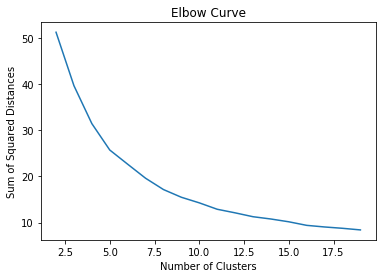

In [30]:
n_clusters = range(2, 20)

kmeans = [KMeans(n_clusters = i, random_state=0).fit(venue_count_normalized) for i in n_clusters]
inertias = [kmean.inertia_ for kmean in kmeans]

plt.plot(n_clusters, inertias)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Curve')

plt.show()

In [31]:
# we'll set the same K to 8
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(venue_count_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 2, 2, 2, 7, 4, 0, 4, 0, 0], dtype=int32)

In [32]:
# add clustering labels
venue_count_normalized.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhood_merged = venue_count_normalized

neighborhood_merged = neighborhood_merged.merge(neighborhoods, on='Neighborhood')

neighborhood_merged.head() # check the last columns!

,Neighborhood,Cluster Labels,White Restaurant,East Asian Restaurant,Hispanic Restaurant,Other Asian Restaurant,Asian Restaurant,Caribbean Restaurant,African Restaurant,Borough,Latitude,Longitude
0,Allerton,5,0.166667,0.50,0.333333,0.000000,0.0,0.000000,0.0,Bronx,40.865788,-73.859319
1,Annadale,2,0.750000,0.25,0.000000,0.000000,0.0,0.000000,0.0,Staten Island,40.538114,-74.178549
2,Arlington,2,0.666667,0.00,0.000000,0.000000,0.0,0.333333,0.0,Staten Island,40.635325,-74.165104
3,Arrochar,2,0.666667,0.00,0.166667,0.166667,0.0,0.000000,0.0,Staten Island,40.596313,-74.067124
4,Arverne,7,0.000000,0.00,0.000000,1.000000,0.0,0.000000,0.0,Queens,40.589144,-73.791992


#### Examine Clusters 

Let's examine each cluster, printing the size of the cluster and the mean of each category's contribution.

In [33]:
cluster_infos = []
cluster_columns = ['Size']
cluster_columns.extend(category_names)
for i in range(kclusters):
    cluster = neighborhood_merged[neighborhood_merged['Cluster Labels']==i]
    cluster_info = [cluster.shape[0]]
    print('Cluster {}: size({})'.format(i+1,cluster.shape[0]))
    category_contributions = cluster.iloc[:, 2:-3].mean()
    cluster_info.extend(category_contributions.values)
    print(category_contributions.sort_values(ascending=False))
    print('')
    cluster_infos.append(cluster_info)
cluster_info_df = pd.DataFrame(cluster_infos, columns=cluster_columns, index=['Cluster {}'.format(i+1) for i in range(kclusters) ])
cluster_info_df

Cluster 1: size(46)
East Asian Restaurant     0.500335
White Restaurant          0.361791
Hispanic Restaurant       0.051507
Other Asian Restaurant    0.044268
Asian Restaurant          0.029120
Caribbean Restaurant      0.012980
African Restaurant        0.000000
dtype: float64

Cluster 2: size(14)
Hispanic Restaurant       0.881997
East Asian Restaurant     0.065267
White Restaurant          0.020426
Other Asian Restaurant    0.018233
Caribbean Restaurant      0.012490
Asian Restaurant          0.001587
African Restaurant        0.000000
dtype: float64

Cluster 3: size(38)
White Restaurant          0.790854
East Asian Restaurant     0.061333
Hispanic Restaurant       0.053447
Other Asian Restaurant    0.051811
Asian Restaurant          0.020238
African Restaurant        0.013545
Caribbean Restaurant      0.008772
dtype: float64

Cluster 4: size(14)
Caribbean Restaurant      0.750000
East Asian Restaurant     0.197619
Asian Restaurant          0.038095
Hispanic Restaurant       0.0142

,Size,White Restaurant,East Asian Restaurant,Hispanic Restaurant,Other Asian Restaurant,Asian Restaurant,Caribbean Restaurant,African Restaurant
Cluster 1,46,0.361791,0.500335,0.051507,0.044268,0.029120,0.012980,0.000000
Cluster 2,14,0.020426,0.065267,0.881997,0.018233,0.001587,0.012490,0.000000
Cluster 3,38,0.790854,0.061333,0.053447,0.051811,0.020238,0.008772,0.013545
Cluster 4,14,0.000000,0.197619,0.014286,0.000000,0.038095,0.750000,0.000000
Cluster 5,64,0.390915,0.195049,0.165121,0.113662,0.109523,0.018417,0.007314
Cluster 6,65,0.101643,0.322358,0.426974,0.058565,0.030350,0.055916,0.004194
Cluster 7,25,0.021605,0.823206,0.040161,0.010320,0.076708,0.028000,0.000000
Cluster 8,9,0.000000,0.262963,0.044444,0.622222,0.035185,0.035185,0.000000


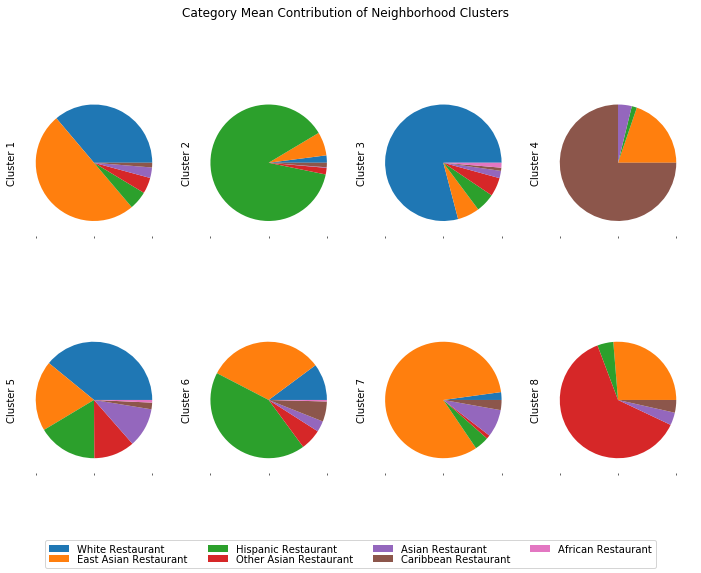

In [38]:
axes = cluster_info_df[category_names].transpose().plot(kind='pie', subplots=True, layout=(2,4), figsize=(12, 8), legend=False, labels=None, title="Category Mean Contribution of Neighborhood Clusters")
plt.figlegend(axes[0][0].patches, category_names, loc='lower center', ncol=4, labelspacing=0.)

We can see from the result (the cluster order may change):

1. The first cluster is **Asian Diverse**.
2. The second cluster is **Hispanic**.
3. The third cluster is **White** dominant.
4. The forth cluster is **Caribbean**.
5. The fifth cluster is **White** but diverse. We'll label it **White Diverse**.
6. The sixth cluster is **Hispanic Diverse**.
7. The seventh cluster is **East Asian**.
8. The eighth cluster is **Asian** dominant.

#### Visualize Cluster

Let's visualize the clusters with different colors on the map.

In [35]:
cluster_names = ['Asian Diverse', 'Hispanic', 'White', 'Caribbean', 'White Diverse', 'Hispanic Diverse', 'East Asian', 'Asian']
draw_map_clusters(neighborhood_merged, cluster_names=cluster_names)


We can see those infos from this map:

1. Most neighborhoods on *Staten Island* are **White** or **White Diverse**;
2. Almost all neighborhoods in *Manhattan* are labeled **White** or **White Diverse**;
3. **Hispanic** or **Hispanic Diverse** neighborhoods are distributed in `The Bronx` and `Queens`;
4. **Caribbean** neighborhoods are mainly located in three geographical clusters in `The Bronx` and `Queens` and `Brooklyn`;

## Discussion

As it showed in two clustering results, the ethnic neighborhoods distribution patterns are almost the same. The only difference is that the neighborhoods in *Manhattan* were labeled **White**/**White Diverse** in the later clustering instead of **Diverse**.

To verify our clustering result, we need to compare it to the real ethnic distribution data in New York City.


We find there's a figure showing the **Predominant race/ethnicity by tract** from a research called ["COMMUNITIES OF INTEREST" IN NEW YORK CITY](https://www.gc.cuny.edu/Page-Elements/Academics-Research-Centers-Initiatives/Centers-and-Institutes/Center-for-Urban-Research/CUR-research-initiatives/Communities-of-Interest-in-New-York-City).

To clearly comparing our result with this figure, we'll take the same color for each ethnic groups from this figure and draw our map again.

In [36]:
cluster_names = ['Asian Diverse', 'Hispanic', 'White', 'Caribbean', 'White Diverse', 'Hispanic Diverse', 'East Asian', 'Asian']
cluster_colors = ['#9fe789', '#ff7f00', '#58aed9', '#b72600', '#c6dbef', '#ffbf64', '#c2ffbe', '#9fe789',]

draw_map_clusters(neighborhood_merged, cluster_names=cluster_names, cluster_colors=cluster_colors)

In this map, we can see the location patterns of the color points are almost identical to the figure from that research. At least these three patterns are the same:

1. Neighborhoods in *Staten Island* and *Manhattan* are mostly **White** dominant.
2. The **Hispanic** neighborhoods are mainly distributed in *The Bronx* and area between *Brooklyn* and *Queens*.
3. The **Caribbean** neighborhoods can be divided into three geographical clusters in *The Bronx*, *Queens* and *Brooklyn*.

But there are also some differences between the two:

1. The **Asian** neighborhoods distribution pattern, which scatter everywhere, is not like the previous one that most **Asian** neighborhoods are in *Queens*.
2. The **African** neighborhoods are not shown on our map.

For the first difference, maybe that's because the **Asian** food venues, such as **Chinese Restaurant**, **Japanese Restaurant** are so ubiquitous that make it hard to represent the respective ethnic group distribution.

For the second difference, because there's little **African Restaurant** in our dataset, it's hard for it to be a dominant contribution for any neighborhood.

To improve the result, maybe some other food venues should be included in our dataset, as in our analysis we only consider those ethnic food categories literally. A thorough study of the culture background for all food venue categories could help us include more as ethnic categories, which may could fix the data bias problem for categories like **African**.

## Conclusion <a name="conclusion"></a>

In this project, we clustered neighborhoods in New York City into different ethnic groups base on types of food venues nearby using k-means algorithm. We did the clustering twice, the first try with 40 categories as features and the second one with only 7 generalized categories. The patterns in both clustering results are almost the same, and the clustering result of ethnic groups is comparable to the real race distribution of New York City. Thus we provide a good way to cluster and identify the dominant ethnicity of neighborhoods.